In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [4]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [5]:
path  = '/content/drive/MyDrive/Dataset/forms'
poems = get_text_files(path)
print("There are",len(poems),"poems in the dataset")

There are 6332 poems in the dataset


In [6]:
ballads = get_text_files(path, folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [7]:
txt = poems[5].open().read(); #read the first file
print(txt)

My love is pure as honey, made of selective nectars
A work in tandem by bees, taking the sorrows of my life:
Some buried petals of the past mixed with the fragrance of presence,
weaving the relationships; by the threads of words.


In [8]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [9]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

all_ballads = flatten(ballads)

In [10]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [11]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [12]:
show_at(tls.train, 0)

The ring is on my hand,
And the wreath is on my brow;
Satin and jewels grand
Are all at my command,
And I am happy now.
And my lord he loves me well;
But, when first he breathed his vow,
I felt my bosom swell-
For the words rang as a knell,
And the voice seemed his who fell
In the battle down the dell,
And who is happy now.
But he spoke to re-assure me,
And he kissed my pallid brow,
While a reverie came o'er me,
And to the church-yard bore me,
And I sighed to him before me,
Thinking him dead D'Elormie,
"Oh, I am happy now!"
And thus the words were spoken,
And this the plighted vow,
And, though my faith be broken,
And, though my heart be broken,
Here is a ring, as token
That I am happy now!
Would God I could awaken!
For I dream I know not how!
And my soul is sorely shaken
Lest an evil step be taken,-
Lest the dead who is forsaken
May not be happy now.


In [13]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (5778 > 1024). Running this sequence through the model will result in indexing errors


In [14]:
dls.show_batch(max_n=2)

,text,text_
0,"translated by Will Kirkland\nThe moon came into the forge\nin her bustle of flowering nard.\nThe little boy stares at her, stares.\nThe boy is staring hard.\nIn the shaken air\nthe moon moves her amrs,\nand shows lubricious and pure,\nher breasts of hard tin.\n""Moon, moon, moon, run!\nIf the gypsies come,\nthey will use your heart\nto make white necklaces and rings.""\n""Let me dance, my little one.\nWhen the gypsies come,\nthey'll find you on the anvil\nwith your lively eyes closed tight.\n""Moon, moon, moon, run!\nI can feelheir horses come.""\n""Let me be, my little one,\ndon't step on me, all starched and white!""\nCloser comes the the horseman,\ndrumming on the plain.\nThe boy is in the forge;\nhis eyes are closed.\nThrough the olive grove\ncome the gypsies, dream and bronze,\ntheir heads held high,\ntheir hooded eyes.\nOh, how the night owl calls,\ncalling, calling from its tree!","lated by Will Kirkland\nThe moon came into the forge\nin her bustle of flowering nard.\nThe little boy stares at her, stares.\nThe boy is staring hard.\nIn the shaken air\nthe moon moves her amrs,\nand shows lubricious and pure,\nher breasts of hard tin.\n""Moon, moon, moon, run!\nIf the gypsies come,\nthey will use your heart\nto make white necklaces and rings.""\n""Let me dance, my little one.\nWhen the gypsies come,\nthey'll find you on the anvil\nwith your lively eyes closed tight.\n""Moon, moon, moon, run!\nI can feelheir horses come.""\n""Let me be, my little one,\ndon't step on me, all starched and white!""\nCloser comes the the horseman,\ndrumming on the plain.\nThe boy is in the forge;\nhis eyes are closed.\nThrough the olive grove\ncome the gypsies, dream and bronze,\ntheir heads held high,\ntheir hooded eyes.\nOh, how the night owl calls,\ncalling, calling from its tree!\n"
1,";\nBut Mark set one foot on the shield,\nOne on some sundered rock upheeled,\nAnd towered above the tossing field,\nA statue on a roof.\nDealing far blows about the fight,\nLike thunder-bolts a-roam,\nLike birds about the battle-field,\nWhile Ogier writhed under his shield\nLike a tortoise in his dome.\nBut hate in the buried Ogier\nWas strong as pain in hell,\nWith bare brute hand from the inside\nHe burst the shield of brass and hide,\nAnd a death-stroke to the Roman's side\nSent suddenly and well.\nThen the great statue on the shield\nLooked his last look around\nWith level and imperial eye;\nAnd Mark, the man from Italy,\nFell in the sea of agony,\nAnd died without a sound.\nAnd Ogier, leaping up alive,\nHurled his huge shield away\nFlying, as when a juggler flings\nA whizzing plate in play.\nAnd held two arms up rigidly,\nAnd roared to all the Danes:\n""Fallen is Rome, yea, fallen\nThe city of the plains!\n""Shall","\nBut Mark set one foot on the shield,\nOne on some sundered rock upheeled,\nAnd towered above the tossing field,\nA statue on a roof.\nDealing far blows about the fight,\nLike thunder-bolts a-roam,\nLike birds about the battle-field,\nWhile Ogier writhed under his shield\nLike a tortoise in his dome.\nBut hate in the buried Ogier\nWas strong as pain in hell,\nWith bare brute hand from the inside\nHe burst the shield of brass and hide,\nAnd a death-stroke to the Roman's side\nSent suddenly and well.\nThen the great statue on the shield\nLooked his last look around\nWith level and imperial eye;\nAnd Mark, the man from Italy,\nFell in the sea of agony,\nAnd died without a sound.\nAnd Ogier, leaping up alive,\nHurled his huge shield away\nFlying, as when a juggler flings\nA whizzing plate in play.\nAnd held two arms up rigidly,\nAnd roared to all the Danes:\n""Fallen is Rome, yea, fallen\nThe city of the plains!\n""Shall no"


In [15]:
class DropOutput(Callback):
    def after_pred(self):
      self.learn.pred = self.pred[0]
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [16]:
learn.validate()

(#2) [4.17626953125,65.1224594116211]

SuggestedLRs(valley=7.585775892948732e-05)

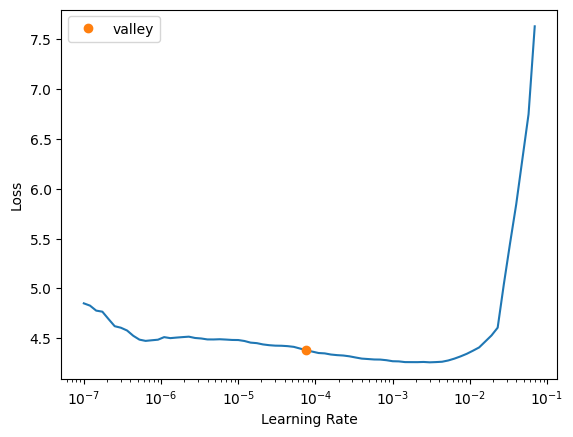

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.129602,3.887940,48.810219,00:35


In [30]:
prompt = 'lips' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 2])

In [31]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
lips.
"I'm sorry," he said, "but I don't know what to do."
He went on to say that he was sorry for what he had done, but that it was not good for him to have done it again. He said that if he did not go
